# Imports

In [1]:
import pandas as pd
import numpy as np

from collections import defaultdict

from tensorflow import keras

from matplotlib import pyplot as plt

from functions.data_processing import create_set_cnn
from functions.prediction import make_predictions, generate_pdda_preds
from functions.visualization import posHeatmapXY, spatial_plot

import warnings
warnings.filterwarnings("ignore")

# Dataset Import

The dataset is hosted publicly at https://doi.org/10.5281/zenodo.6303665.

In [2]:
datadir = 'Dataset' # path to data folder
modeldir = 'models' # path to model folder (optional, if you want to save models' weights)
preds_dir = 'preds' # path to model folder (optional, if you want to save models' predictions)

In [3]:
#define basic values
rooms = ['testbench_01', 'testbench_01_furniture_low', 'testbench_01_furniture_mid', 'testbench_01_furniture_high']
concrete_rooms = ['testbench_01_furniture_low_concrete', 'testbench_01_furniture_mid_concrete', 'testbench_01_furniture_high_concrete']
other_scenarios = ['testbench_01_rotated_anchors']
anchors = ['anchor1', 'anchor2', 'anchor3', 'anchor4']
channels = ['37','38','39']
polarities = ['V','H']

In [4]:
import json
import os
os.getcwd()

'C:\\Users\\nini\\Desktop\\Libra\\sensors-positioning'

In [5]:
#read data
data = defaultdict(lambda: defaultdict(lambda: defaultdict (lambda: defaultdict(list))))

anchor_data = defaultdict(lambda: defaultdict(lambda: defaultdict (lambda: defaultdict(list))))
final_df = pd.DataFrame()
for room in rooms + concrete_rooms + other_scenarios: 
    for channel in channels:  
        for polarity in polarities: 
             
            tag_filename = f'{datadir}/{room}/tag_ml_export_CH{channel}_{polarity}.json'
            with open(tag_filename, encoding='utf-8-sig') as fp:
                tag_dataset = json.loads(''.join(line.strip() for line in fp))

            tag_df = pd.json_normalize(tag_dataset)
            tag_df['room'] = str(room)
            tag_df['channel'] = str(channel)
            tag_df['polarity'] = str(polarity)
            # tag_df = pd.read_json(tag_filename, orient='records')
            
            anchor_filename = f'{datadir}/{room}/anchor_ml_export_CH{channel}_{polarity}.json'
            
            with open(anchor_filename, encoding='utf-8-sig') as fp:
                anchor_dataset = json.loads(''.join(line.strip() for line in fp))

            anchor_df = pd.json_normalize(anchor_dataset)
            
            # anchor_df = pd.read_json(anchor_filename, orient='records')

            df = tag_df.merge(anchor_df)
            # remove calibration points
            df.drop(df[(df['x_tag']==0).values | (df['y_tag']==0).values | (df['z_tag']==0).values].index, inplace=True)
            for anchor in anchors:
                data[room][anchor][channel][polarity] = df[df['anchor']==int(anchor[-1])]
                anchor_data[room][anchor][channel][polarity] = anchor_df
            final_df = pd.concat([final_df, df])

KeyboardInterrupt: 

In [ ]:
cols = list(final_df)

In [ ]:
new_order = [ 'point','room','anchor','channel', 'polarity', 'reference_power','pdda_input_real','pdda_input_imag', 'relative_power', 'true_phi', 'true_theta','x_tag', 'y_tag', 'z_tag'] 
new_order += list((set(cols) - set(new_order)))

In [ ]:
final_df = final_df[new_order]
final_df = final_df.sort_values(['point', 'room', 'anchor', 'channel', 'polarity'])
final_df.reset_index(drop=True, inplace=True)

In [ ]:
# final_df.to_pickle('libra_dataset.pkl')

# Data Processing

The selected number of training and validation points is small so the point selection is done in an orderly fashion.

In [20]:
#split points into train/test/val points
points = data['testbench_01']['anchor1']['37']['H'].iloc[:, 1:7]

# only point locations that appear in all simulated environments are used.
# some point locations that fall ontop of furniture are thus thrown away.
for room in rooms + concrete_rooms:
    for anchor in anchors:
        for channel in channels:
            for polarization in ['H','V']:
                points = pd.merge(points, data[room][anchor][channel][polarization]['point'], on='point')

# grid of training points
xs = sorted(np.unique(points['x_tag']))[::18]
ys = sorted(np.unique(points['y_tag']))[::9]
train_points = points[points['x_tag'].isin(xs) & points['y_tag'].isin(ys)]

# grid of validation points
xs = sorted(np.unique(points['x_tag']))[3::10]
ys = sorted(np.unique(points['y_tag']))[3::10]
val_points = points[points['x_tag'].isin(xs) & points['y_tag'].isin(ys)]

test_points = points.drop(index=train_points.index).drop(index=val_points.index)

In [21]:
print(f'Training Set Size:\t{len(train_points)}')
print(f'Validation Set Size:\t{len(val_points)}')
print(f'Testing Set Size:\t{len(test_points)}')

Training Set Size:	14
Validation Set Size:	27
Testing Set Size:	2353


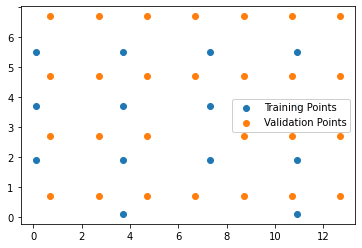

In [22]:
plt.scatter(train_points.iloc[:,1:2].values,train_points.iloc[:,2:3].values)
plt.scatter(val_points.iloc[:,1:2].values,val_points.iloc[:,2:3].values)
plt.legend(['Training Points', 'Validation Points'], framealpha=0.94, fancybox=True)
ax = plt.gca()
ax.set_xticklabels(range(-2,15,2))
ax.set_yticklabels(range(-1,7,1))
plt.show()

Split the dataset based on the picked training, validation and testing points. Additionally, the create_set function processes the IQ and RSSI data by applying IQ phase shifting and RSSI normalization.

The training set is augmented by reducing amplitude of IQ values and RSSI for randomly picked anchors. Finally, the IQ-images are created.

In [23]:
#creat train/test/val sets for cnn
x_train, y_train = create_set_cnn(data, rooms, train_points, augmentation=True)
x_val, y_val = create_set_cnn(data, rooms + concrete_rooms + other_scenarios, val_points)                         
x_test, y_test = create_set_cnn(data, rooms + concrete_rooms + other_scenarios, test_points)

['reference_power', 'pdda_input_real_1', 'pdda_input_real_2', 'pdda_input_imag_2', 'pdda_input_real_3', 'pdda_input_imag_3', 'pdda_input_real_4', 'pdda_input_imag_4', 'pdda_input_real_5', 'pdda_input_imag_5']
['reference_power', 'pdda_input_real_1', 'pdda_input_real_2', 'pdda_input_imag_2', 'pdda_input_real_3', 'pdda_input_imag_3', 'pdda_input_real_4', 'pdda_input_imag_4', 'pdda_input_real_5', 'pdda_input_imag_5']
['reference_power', 'pdda_input_real_1', 'pdda_input_real_2', 'pdda_input_imag_2', 'pdda_input_real_3', 'pdda_input_imag_3', 'pdda_input_real_4', 'pdda_input_imag_4', 'pdda_input_real_5', 'pdda_input_imag_5']
['reference_power', 'pdda_input_real_1', 'pdda_input_real_2', 'pdda_input_imag_2', 'pdda_input_real_3', 'pdda_input_imag_3', 'pdda_input_real_4', 'pdda_input_imag_4', 'pdda_input_real_5', 'pdda_input_imag_5']
['reference_power', 'pdda_input_real_1', 'pdda_input_real_2', 'pdda_input_imag_2', 'pdda_input_real_3', 'pdda_input_imag_3', 'pdda_input_real_4', 'pdda_input_imag_4

KeyError: 'power'

# Training

In [ ]:
from functions.models import cnnArch
model_arch = cnnArch
model_arch_name = 'cnn_arch'

In [ ]:
#training parameters
fit_params = {'batch_size': 128, 'validation_batch_size':32, 'epochs': 1500, 'verbose': 1, 
              'callbacks': [keras.callbacks.EarlyStopping(monitor='val_mae', mode='min', verbose=0, patience=75, restore_best_weights=True)]}
learning_rate = 0.0005

In [ ]:
load = False # load an already saved model

if load:
    models_dict = {}
    for room in rooms:
        models_dict[room] = keras.models.load_model(f'{modeldir}/{model_arch_name}/{room}')

else:

    models_dict = defaultdict(lambda: model_arch(learning_rate).model)

    for training_room in rooms:

        print(training_room)
        models_dict[training_room] = model_arch(learning_rate).model

        ytrain = pd.concat([y_train[training_room][anchor]['37'] for anchor in anchors], axis=1)
        yval = pd.concat([y_val[training_room][anchor]['37'] for anchor in anchors], axis=1)

        models_dict[training_room].fit(x_train[training_room], ytrain,
                                    validation_data=(x_val[training_room], yval), 
                                    **fit_params)

In [ ]:
save =  False # save the model

if save:
    for room in rooms:
        models_dict[room].save(f'{modeldir}/{model_arch_name}/{room}')

# Predictions

In [ ]:
# generate AoA and position predictions as well as mean euclidean distance error 
# and AoA mean absolute error for all training and testing room combinations
preds, true_pos = make_predictions(x_test, y_test, models_dict, training_rooms=rooms, 
                                        testing_rooms=rooms + concrete_rooms + other_scenarios,
                                        test_points=test_points, anchor_data=anchor_data)

In [ ]:
def default_to_regular(d):
    if isinstance(d, (defaultdict, dict)):
        d = {k: default_to_regular(v) for k, v in d.items()}
    return d

In [ ]:
# save the predictions dictionary
save_preds = False
if save_preds:
    results_path = f'{preds_dir}/preds_{model_arch_name}.npy'
    np.save(results_path, default_to_regular(preds))

In [ ]:
# load the predictions dictionary
load_preds = False
if load_preds:
    preds = np.load(f'{preds_dir}/preds_{model_arch_name}.npy', allow_pickle=True)[()]

## PDDA

In [ ]:
#produce pdda predictions
pdda_res = generate_pdda_preds(data, rooms + concrete_rooms + other_scenarios, test_points, anchor_data)

# Results

In [ ]:
#produce pos maes heatmap
posHeatmapXY(preds['pos_maes'][:,:7], pdda_res['pos_maes'][:7])

In [ ]:
#produce error per point plot
spatial_plot(preds['pos_preds']['testbench_01_furniture_low']['testbench_01_furniture_high'], true_pos, testing_room = 'testbench_01_furniture_high', mode = 'xy',vmax = 3, cmap = 'PuBu')